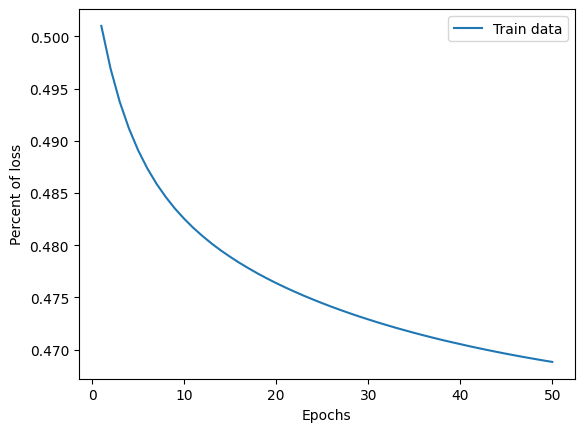

Accuracy for titanic.test: 0.7942583732057417
Epoch 1/100
28/28 [==============================] - 1s 4ms/step - loss: 0.6862 - accuracy: 0.6016
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6752 - accuracy: 0.6016
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6641 - accuracy: 0.6184
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6397
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6269 - accuracy: 0.6958
Epoch 6/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6046 - accuracy: 0.7037
Epoch 7/100
28/28 [==============================] - 0s 4ms/step - loss: 0.5736 - accuracy: 0.7205
Epoch 8/100
28/28 [==============================] - 0s 4ms/step - loss: 0.5451 - accuracy: 0.7475
Epoch 9/100
28/28 [==============================] - 0s 4ms/step - loss: 0.5300 - accuracy: 0.7609
Epoch 10/100
28/28 [==============================] - 0s 3ms/st

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer

# Question 1:
# The features included are: sex, fare, age, embarked, subsip
# What I did for the categorical features like embarked, sex, are: I transformed into numerical format using label encoding
# What I did for subsip: I transformed it into numeracal format using one-hot encoding
# The learning rate used is 0.001
train_data = pd.read_csv('/content/titanic.train.csv')
test_data = pd.read_csv('/content/titanic.test.csv')

# preprocess the data for future training.
def preprocess_titanic_data(df):
  # We drop a few columns that are irrevalent to the result. The reaons why we dropped them are the following:
  # name / ticket number / home.dest: they are unique to each person and are irrevalent to the final result.
  # boat / cabin / body have many missing columns.
    dropped_cols = ['name', 'ticket', 'home.dest','boat','cabin', 'body', 'Unnamed: 0']
    df = df.drop([col for col in dropped_cols if col in df.columns], axis=1)

    # There are a few missing values for age and fare columns, but I am not able to exclude them since they are
    # revelant to the generating the result of whether a person is alive. Therefore, I create an imputer that
    # stands for the general mean value of that column, and fill in the missing values with the mean value
    imputer = SimpleImputer(strategy='mean')
    df['age'] = imputer.fit_transform(df[['age']])
    df['fare'] = imputer.fit_transform(df[['fare']])

    # sex is a categorical column, therefore, I have to first transform it
    label_encoder_sex = LabelEncoder()
    df['sex'] = label_encoder_sex.fit_transform(df['sex'].astype(str))

    # embarked is a categorical column, therefore, I have to first transform it
    label_encoder_embarked = LabelEncoder()
    df['embarked'] = label_encoder_embarked.fit_transform(df['embarked'].astype(str))

    # sibsp is also a categorical column, but I transfrom it later in the method transform_sibsp
    return df

# transfrom the categorical column sibsp into several numerical columns with the following rule:
# No Siblings | 1 Sibling | 2 Siblings | 3 Siblings | 4+ Siblings
def transform_sibsp(df):
    sibsp_transformed = pd.DataFrame({
        'No Siblings': df['sibsp'] == 0,
        '1 Sibling': df['sibsp'] == 1,
        '2 Siblings': df['sibsp'] == 2,
        '3 Siblings': df['sibsp'] == 3,
        '4+ Siblings': df['sibsp'] >= 4
    }).astype(int)
    return pd.concat([df.drop('sibsp', axis=1), sibsp_transformed], axis=1)


# split the data and drop the survived column
X_train = train_data.drop('survived', axis=1)
y_train = train_data['survived']
X_test = test_data.drop('survived', axis=1)
y_test = test_data['survived']

# preprocess the data
X_train_preprocessed = transform_sibsp(preprocess_titanic_data(X_train))
X_test_preprocessed = transform_sibsp(preprocess_titanic_data(X_test))

# normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_preprocessed)
X_test_normalized = scaler.transform(X_test_preprocessed)

# train the training data using logistic regression model
sgd = SGDClassifier(loss='log_loss', penalty=None, max_iter=1000, warm_start=True, learning_rate='constant', eta0=0.001)
number_of_epochs = 50
train_loss = []
for epoch in range(number_of_epochs):
    sgd.fit(X_train_normalized, y_train)
    y_prob = sgd.predict_proba(X_train_normalized)
    loss = log_loss(y_train, y_prob)
    train_loss.append(loss)

# plot the data and create a diagram
plt.plot(range(1, number_of_epochs + 1), train_loss, label='Train data')
plt.xlabel('Epochs')
plt.ylabel('Percent of loss')
plt.legend()
plt.show()

# use the logistic regression model to calculate the result and print the accuracy
y_train_pred = sgd.predict(X_train_normalized)
y_test_pred = sgd.predict(X_test_normalized)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy for titanic.test:", test_accuracy)

# create a neural network model with hidden layers
neural_network_model = Sequential([
    InputLayer(input_shape=(X_train_normalized.shape[1],)),
    Dense(1, activation='relu'),
    Dense(10, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')
])

# compile the neural network model
neural_network_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train the neural network model again
training_history = neural_network_model.fit(
    X_train_normalized, y_train,
    epochs=100, batch_size=32,
    verbose=1
)

print(f"Neural Network Test Set Accuracy: {neural_network_model.evaluate(X_test_normalized, y_test, verbose=0)[1] * 100:.2f}%")


